---
### 招聘公务员问题
> 2004年国赛D题

#### 1. 模型准备

In [1]:
import numpy as np
import cvxpy as cp
import sympy as sp
sp.init_printing(use_latex=True)
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Times New Roman + SimSun + WFM Sans SC']
plt.rcParams['mathtext.fontset']='stix'
# Times New Roman + SimSun + WFM Sans SC
# simsum宋体, times new roman -*, simhei黑体, kaiti楷体, 
# dengxian等线, fangsong仿宋, Microsoft Yahei微软雅黑
plt.rcParams['axes.unicode_minus']=False   
plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = [4, 3]
# plt.rcParams['font.size'] = 12
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'

In [2]:
v = np.array([1, 2, 3, 4, 5])  # 评语集 v = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
f1 = 0.01
f3 = 0.8
f5 = 1
alpha, beta, a, b = sp.symbols('α, β, a, b', real=True)
x = sp.symbols('x', integer=True)
f1_3 = (1+alpha*(x - beta)**-2)**-1     # 柯西分布隶属函数
f3_5 = a*sp.log(x) + b

In [3]:
eq1 = sp.Equality(f1_3.subs(x, 1), f1)
eq2 = sp.Equality(f1_3.subs(x, 3), f3)
ret1_3 = sp.nonlinsolve([eq1, eq2], [alpha, beta])
ret1_3
# 此处有两组解，下面使用第二组，因为第一组对应的隶属函数非单调递增

In [4]:
alpha_r, beta_r = list(ret1_3)[1]
ff1_3 = sp.lambdify(x, f1_3.subs({alpha: alpha_r, beta: beta_r}), 'numpy')
f2 = ff1_3(2)
ff1_3(1), ff1_3(3), f2

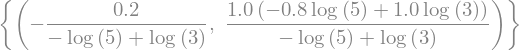

In [5]:
eq3 = sp.Eq(f3_5.subs(x, 3), 0.8)
eq4 = sp.Eq(f3_5.subs(x, 5), 1)
ret3_5 = sp.nonlinsolve([eq3, eq4], [a, b])
ret3_5

In [6]:
a_r, b_r = list(ret3_5)[0]
a_r, b_r = a_r.n(), b_r.n()
ff3_5 = sp.lambdify(x, f3_5.subs({a: a_r, b: b_r}), 'numpy')
f4 = ff3_5(4)
ff3_5(3), ff3_5(5), f4

In [7]:
def membership_f(x):
    if (1 <= x and x <= 3):
        return ff1_3(x)
    elif (3 <= x and x <= 5):
        return ff3_5(x)

quant_score = list(map(membership_f, v))

def score(x):
    return quant_score[int(x-1)]

employee = np.loadtxt('../../14第14章  综合评价方法/anli14_1_1.txt')
ability = employee[:, -4:]
ability_val = np.zeros_like(ability)
for i in range(len(ability)):
    for j in range(len(ability[0])):
        ability_val[i, j] = score(ability[i, j])

retest = ability_val.mean(axis=1)   # 对四项评分取相同的权重
retest          # 复试成绩

array([0.95631708, 0.92815854, 0.80928239, 0.93447562, 0.90631708,
       0.83744093, 0.90631708, 0.92815854, 0.93447562, 0.80928239,
       0.80928239, 0.92815854, 0.80928239, 0.83744093, 0.90631708,
       0.90631708])

In [8]:
from sklearn.preprocessing import minmax_scale

score = np.array([employee[:, 0], retest]).T
score_std = minmax_scale(score, axis=0) # 极差变换法
score_std       # 规范化成绩

array([[1.00000000e+00, 1.00000000e+00],
       [8.82352941e-01, 8.08490504e-01],
       [8.82352941e-01, 0.00000000e+00],
       [7.05882353e-01, 8.51453695e-01],
       [5.88235294e-01, 6.59944199e-01],
       [5.88235294e-01, 1.91509496e-01],
       [4.11764706e-01, 6.59944199e-01],
       [4.11764706e-01, 8.08490504e-01],
       [4.11764706e-01, 8.51453695e-01],
       [4.11764706e-01, 8.88178420e-16],
       [2.94117647e-01, 8.88178420e-16],
       [2.35294118e-01, 8.08490504e-01],
       [1.17647059e-01, 8.88178420e-16],
       [1.17647059e-01, 1.91509496e-01],
       [5.88235294e-02, 6.59944199e-01],
       [0.00000000e+00, 6.59944199e-01]])

In [9]:
gamma = 0.5     # 初试和复试成绩的权重
performance = score_std[:, 0]*gamma + score_std[:, 1]*(1 - gamma)
print(performance)  # 综合成绩
ranking = np.argsort(np.argsort(-performance, kind='mergesort'), kind='mergesort') + 1
print(ranking)     # 按原数据次序的排名

[1.         0.84542172 0.44117647 0.77866802 0.62408975 0.38987239
 0.53585445 0.61012761 0.6316092  0.20588235 0.14705882 0.52189231
 0.05882353 0.15457828 0.35938386 0.3299721 ]
[ 1  2  9  3  5 10  7  6  4 13 15  8 16 14 11 12]


#### 2. 问题 (1)
$$择优按需录取 = 择优（被聘人员综合成绩最高） +\ 按需（部门对被聘人员满意度最高）$$

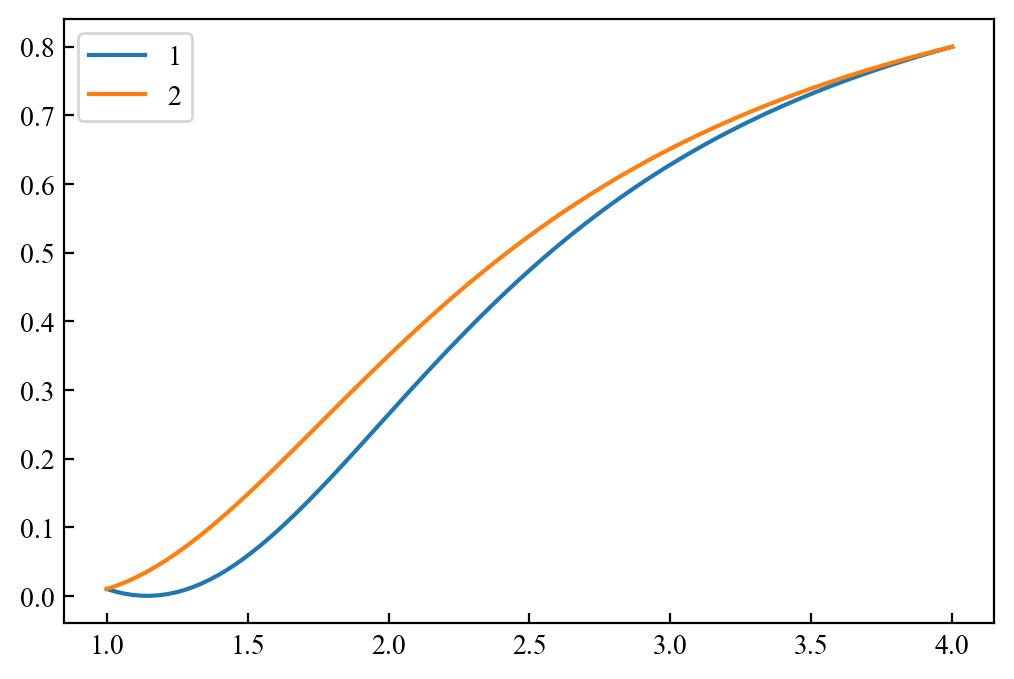

In [10]:
V = np.arange(1, 8)
f1, f4, f7 = 0.01, 0.8, 1
f1_4 = f1_3
f4_7 = f3_5
eq1 = sp.Eq(f1_4.subs(x, 1), f1)
eq2 = sp.Eq(f1_4.subs(x, 4), f4)
ret = list(sp.nonlinsolve([eq1, eq2], [alpha, beta]))
f_test1 = f1_4.subs({alpha: ret[0][0], beta: ret[0][1]})
f_test2 = f1_4.subs({alpha: ret[1][0], beta: ret[1][1]})

ff_test1 = sp.lambdify(x, f_test1, 'numpy')
ff_test2 = sp.lambdify(x, f_test2, 'numpy')
xx = np.linspace(1, 4, 100)
yy1 = ff_test1(xx)
yy2 = ff_test2(xx)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xx, yy1, label='1')
ax.plot(xx, yy2, label='2')
ax.legend()
fig.show()  # choose 2 (ret[1])

In [11]:
ff1_4 = ff_test2
f2, f3 = ff1_4(2), ff1_4(3)

In [12]:
eq3 = sp.Eq(f4_7.subs(x, 4), f4)
eq4 = sp.Eq(f4_7.subs(x, 7), f7)
ab_dict = sp.solve([eq3, eq4], [a, b])
ff4_7 = sp.lambdify(x, f4_7.subs(ab_dict), 'numpy')
f5, f6 = ff4_7(5), ff4_7(6)

In [13]:
quant_score = np.array([f1, f2, f3, f4, f5, f6, f7])
print(quant_score)

[0.01       0.34991927 0.65135375 0.8        0.87974884 0.94490839
 1.        ]


In [14]:
employer = np.loadtxt('../../14第14章  综合评价方法/anli14_1_3.txt')
n = len(employee)
m = len(employer)
course_num = 4
ability = employee[:, -course_num:]
expectation = employer[:, -course_num:]
satisfaction_er = np.zeros((m, n))

for i in range(m):
    for j in range(n):
        score = 0
        for k in range(course_num):
            grade = ability[j, k] - expectation[i, k] + course_num - 1
            score += quant_score[int(grade)]
        score /= course_num
        satisfaction_er[i, j] = score

print(np.round(satisfaction_er, 4))    # 部门对应聘者能力值的满意度（r：单位，c：应聘者）

[[0.8027 0.7065 0.6503 0.7656 0.7074 0.6016 0.7456 0.7237 0.7619 0.574
  0.5949 0.7828 0.6503 0.6494 0.7456 0.7074]
 [0.8399 0.8199 0.6703 0.8199 0.7828 0.6902 0.7828 0.8027 0.8027 0.6224
  0.6016 0.7991 0.6494 0.6424 0.7828 0.7828]
 [0.8399 0.8199 0.6703 0.8199 0.7828 0.6902 0.7828 0.8027 0.8027 0.6224
  0.6016 0.7991 0.6494 0.6424 0.7828 0.7828]
 [0.7981 0.7436 0.5461 0.7818 0.7065 0.7456 0.7065 0.7436 0.8027 0.6703
  0.7257 0.7436 0.6224 0.7456 0.7065 0.7065]
 [0.7981 0.7436 0.5461 0.7818 0.7065 0.7456 0.7065 0.7436 0.8027 0.6703
  0.7257 0.7436 0.6224 0.7456 0.7065 0.7065]
 [0.819  0.7436 0.6148 0.7991 0.7274 0.6902 0.7619 0.7473 0.8027 0.6703
  0.7257 0.7991 0.6703 0.7456 0.7619 0.7274]
 [0.819  0.7436 0.6148 0.7991 0.7274 0.6902 0.7619 0.7473 0.8027 0.6703
  0.7257 0.7991 0.6703 0.7456 0.7619 0.7274]]


In [15]:
x = cp.Variable((m, n), boolean=True)
choose_good = cp.sum(x @ performance)
satisfy = cp.sum(cp.multiply(satisfaction_er, x))
obj = cp.Maximize(choose_good + satisfy)
cons = [
    cp.sum(x) == 8,
    cp.sum(x, axis=0) <= 1,
    1 <= cp.sum(x, axis=1), cp.sum(x, axis=1) <= 2,
]
prob = cp.Problem(obj, cons)
prob.solve(solver='GUROBI')
print(f'最优解为：{x.value}\n\n最优值为：{prob.value}')

最优解为：[[ 1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0.  1. -0.  0. -0. -0. -0.  1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0.  0. -0. -0.  1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0.  0. -0. -0. -0. -0.  1. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0.  1. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.]
 [ 0. -0. -0.  0. -0. -0.  0. -0. -0. -0. -0.  1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0.  1. -0. -0. -0. -0. -0. -0. -0. -0. -0.]]

最优值为：11.90132518721478


In [16]:
employer_ret, employee_ret = np.nonzero(x.value)

print("部门：    ", employer_ret + 1)
print("应聘者：  ", employee_ret + 1)
print("综合得分：", np.round(performance[employee_ret], 4))
print("部门评分：", np.round(satisfaction_er[employer_ret, employee_ret], 4))

部门：     [1 2 2 3 4 5 6 7]
应聘者：   [ 1  2  8  5  9  4 12  7]
综合得分： [1.     0.8454 0.6101 0.6241 0.6316 0.7787 0.5219 0.5359]
部门评分： [0.8027 0.8199 0.8027 0.7828 0.8027 0.7818 0.7991 0.7619]


#### 3. 问题 (2)
综合考虑双方互相的满意度，其中部门对应聘者的满意度已经讨论过，下面只需讨论应聘者对部门的满意度

应聘者对部门的满意度主要与部门的工作条件以及工作类别有关，其中工作类别是否匹配可以视作工作条件的影响是否生效的前提，故可以工作类别的匹配度分别乘以每个部门的平均工作条件（这里对五个工作条件取了等权重），作为应聘者对部门的满意度

至于综合满意度，可以取双方满意度的几何平均值

In [17]:
x = sp.symbols('x', integer=True)
f1_3 = b*sp.log(a - x)
V = [1, 2, 3]       # 评语集 V = {'非常满意': 1, '基本满意': 2, '不满意': 3}
f1 = 1
f3 = 0
eq1 = sp.Eq(f1_3.subs(x, 1), f1)
eq2 = sp.Eq(f1_3.subs(x, 3), f3)
a_r, b_r = sp.solve([eq1, eq2], [a, b])[0]
ff1_3 = sp.lambdify(x, f1_3.subs({a: a_r, b: b_r}), 'numpy')
f2 = ff1_3(2)
quant_score = np.array([f1, f2, f3])
quant_score     # 应聘者对工作单位满意度的定量值

array([1.        , 0.63092975, 0.        ])

In [18]:
voluntary = employee[:, 1:3]
work_type = employer[:, 0]
work_type_satis = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        if work_type[j] == voluntary[i, 0]:
            work_type_satis[i, j] = quant_score[0]
        elif work_type[j] == voluntary[i, 1]:
            work_type_satis[i, j] = quant_score[1]
        else:
            work_type_satis[i, j] = quant_score[2]
print(np.round(work_type_satis, 4))      # 应聘者对部门工作类别的满意度（r：应聘者，c：单位）

[[0.     1.     1.     0.6309 0.6309 0.     0.    ]
 [0.6309 0.     0.     1.     1.     0.     0.    ]
 [1.     0.6309 0.6309 0.     0.     0.     0.    ]
 [0.     0.     0.     0.6309 0.6309 1.     1.    ]
 [0.     0.6309 0.6309 1.     1.     0.     0.    ]
 [0.     0.     0.     1.     1.     0.6309 0.6309]
 [0.6309 0.     0.     0.     0.     1.     1.    ]
 [0.     1.     1.     0.     0.     0.6309 0.6309]
 [1.     0.     0.     0.6309 0.6309 0.     0.    ]
 [0.6309 0.     0.     1.     1.     0.     0.    ]
 [0.6309 0.     0.     0.     0.     1.     1.    ]
 [0.     0.     0.     1.     1.     0.6309 0.6309]
 [0.6309 1.     1.     0.     0.     0.     0.    ]
 [1.     0.     0.     0.6309 0.6309 0.     0.    ]
 [1.     0.     0.     0.     0.     0.6309 0.6309]
 [0.6309 0.     0.     0.     0.     1.     1.    ]]


In [19]:
work_condition = employer[:, 1:6]
satisfaction_ee = work_type_satis * work_condition.mean(axis=1)
print(np.round(satisfaction_ee, 4))     # 应聘者对部门的满意度（以对工作类别的满意度为权重）

[[0.     0.56   0.66   0.4038 0.429  0.     0.    ]
 [0.4669 0.     0.     0.64   0.68   0.     0.    ]
 [0.74   0.3533 0.4164 0.     0.     0.     0.    ]
 [0.     0.     0.     0.4038 0.429  0.68   0.56  ]
 [0.     0.3533 0.4164 0.64   0.68   0.     0.    ]
 [0.     0.     0.     0.64   0.68   0.429  0.3533]
 [0.4669 0.     0.     0.     0.     0.68   0.56  ]
 [0.     0.56   0.66   0.     0.     0.429  0.3533]
 [0.74   0.     0.     0.4038 0.429  0.     0.    ]
 [0.4669 0.     0.     0.64   0.68   0.     0.    ]
 [0.4669 0.     0.     0.     0.     0.68   0.56  ]
 [0.     0.     0.     0.64   0.68   0.429  0.3533]
 [0.4669 0.56   0.66   0.     0.     0.     0.    ]
 [0.74   0.     0.     0.4038 0.429  0.     0.    ]
 [0.74   0.     0.     0.     0.     0.429  0.3533]
 [0.4669 0.     0.     0.     0.     0.68   0.56  ]]


In [20]:
satis = np.sqrt(satisfaction_ee.T * satisfaction_er)    # 以双方满意度的几何平均值作为综合满意度
print(satis.round(4))

[[0.     0.5743 0.6937 0.     0.     0.     0.59   0.     0.7509 0.5177
  0.527  0.     0.551  0.6932 0.7428 0.5747]
 [0.6858 0.     0.4866 0.     0.5259 0.     0.     0.6705 0.     0.
  0.     0.     0.603  0.     0.     0.    ]
 [0.7445 0.     0.5283 0.     0.5709 0.     0.     0.7279 0.     0.
  0.     0.     0.6547 0.     0.     0.    ]
 [0.5677 0.6899 0.     0.5619 0.6724 0.6908 0.     0.     0.5693 0.655
  0.     0.6899 0.     0.5487 0.     0.    ]
 [0.5852 0.7111 0.     0.5792 0.6931 0.7121 0.     0.     0.5868 0.6751
  0.     0.7111 0.     0.5656 0.     0.    ]
 [0.     0.     0.     0.7371 0.     0.5442 0.7198 0.5662 0.     0.
  0.7025 0.5855 0.     0.     0.5717 0.7033]
 [0.     0.     0.     0.6689 0.     0.4938 0.6532 0.5138 0.     0.
  0.6375 0.5313 0.     0.     0.5188 0.6382]]


In [21]:
x = cp.Variable((m, n), boolean=True)
obj = cp.Maximize(cp.sum(cp.multiply(x, satis)))
cons = [
    cp.sum(x) == 8,
    cp.sum(x, axis=0) <= 1,
    1 <= cp.sum(x, axis=1), cp.sum(x, axis=1) <= 2,
]
prob = cp.Problem(obj, cons)
prob.solve(solver='GUROBI')
print(f'最优解为：{x.value}\n\n最优值为：{prob.value}')

最优解为：[[-0. -0. -0. -0. -0. -0. -0. -0.  1. -0. -0. -0. -0. -0.  1. -0.]
 [ 0. -0. -0. -0. -0. -0. -0.  1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [ 1. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  1. -0. -0. -0. -0.]
 [-0.  0. -0. -0. -0.  1. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.]
 [-0. -0. -0.  1. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0.  0. -0. -0.  1. -0. -0. -0. -0. -0. -0. -0. -0. -0.]]

最优值为：5.700920231576309


In [22]:
employer_ret, employee_ret = np.nonzero(x.value)

print("部门：    ", employer_ret + 1)
print("应聘者：  ", employee_ret + 1)
print("综合满意度：", np.round(satis[employer_ret, employee_ret], 4))

部门：     [1 1 2 3 4 5 6 7]
应聘者：   [ 9 15  8  1 12  6  4  7]
综合满意度： [0.7509 0.7428 0.6705 0.7445 0.6899 0.7121 0.7371 0.6532]


####  4. 问题 (3)
对于 $N$ 个应聘者和 $M$ 个用人单位的情况，上述方法仍然适用。当 $N$ 大到一定程度时，可以先“择优”，再“按需”分配